<a href="https://colab.research.google.com/github/archibanerj/Audio-Signal-Classification/blob/main/Audio_Signal_Classification_with_TensorFlow_Starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 2: Setup

In [ ]:
!pip install -q pydub

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

from IPython.display import Audio
from matplotlib import pyplot as plt
from tqdm import tqdm

print(tf.__version__)
print(tfds.__version__)

2.5.0
4.0.1


In [ ]:
dataset = tfds.load("gtzan_music_speech")

Shuffling and writing examples to /root/tensorflow_datasets/gtzan_music_speech/1.0.0.incompleteDMZJMA/gtzan_music_speech-train.tfrecord


Dataset gtzan_music_speech downloaded and prepared to /root/tensorflow_datasets/gtzan_music_speech/1.0.0. Subsequent calls will reuse this data.


# Task 3: Explore the Data

In [ ]:
train = dataset["train"]

data_iter = iter(train)

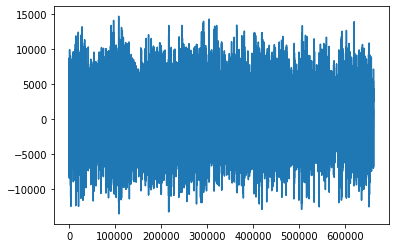

In [ ]:
example = next(data_iter)
example
plt.plot(example['audio'])

In [ ]:
audio = example.get('audio')
label = example.get('label')

print(label.numpy()) #0 corresponds to music, 1 is speech

Audio(audio, rate = 22050)

0


In [ ]:
index_to_class = {0: "music", 1: "speech"}
class_to_index = {"music": 0, "speech": 1}

In [ ]:
def plot_waveform(audio):
    plt.plot(audio)
    plt.xlabel("samples")
    plt.ylabel("amplitude")
    plt.show()

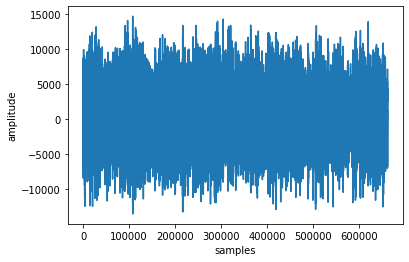

In [ ]:
plot_waveform(audio) #Notice that that there are 600000 samples! -  that is too huge. We process this as a spectogram.
#Additionally, this is not representative of how humans percieve sound

# Task 4: Spectrogram

In [ ]:
#stft - short time fourier transform
#frame_length is the size of window on which the fourier transofrm is applied. 
#frame_step is the number of samples between the two starting points of two consecutive windows. Think of these windows as being sliding convolutions
#fft_length - number of frequency bands that will be calculated
def get_stft(audio, frame_length=2048, frame_step=512, fft_length=256):
    return tf.signal.stft(
        tf.cast(audio, tf.float32),
        frame_length=frame_length,
        frame_step=frame_step,
        fft_length=fft_length
    )

In [ ]:
#We will be ignoring the phase content and only focus on the amplitude (why?) 
#- this will amount to ignoring the complex numbers and use the total amplitude
audio_stft = get_stft(audio)
audio_spec = tf.abs(audio_stft) #ignoring the phase!

In [ ]:
def plot_spec(spec):
    plt.figure(figsize=(12, 4))
    plt.imshow(tf.transpose(spec), cmap="viridis")
    plt.colorbar()
    plt.show()

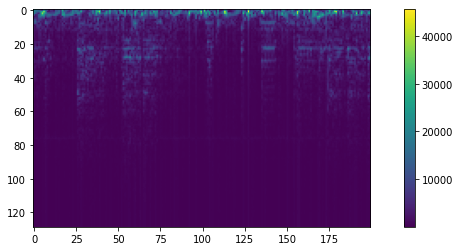

In [ ]:
plot_spec(audio_spec[:200])

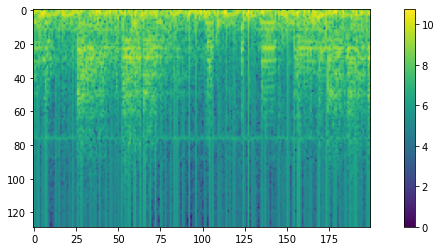

In [ ]:
audio_spec_log = tf.math.log(audio_spec)
plot_spec(audio_spec_log[:200])

#The log spectogram is better because its easier to read the variation in frequency with time. The model might give us better performance with this data
#Also, this has reduced the amplitude value range from 0-30000 to about 0 to 10, which is much easier to read, and is also how the human hearing works.

In [ ]:
def get_spectrogram(audio): #wraps what we have done so far
    audio_stft = get_stft(audio)
    audio_spec = tf.abs(audio_stft)
    return tf.math.log(tf.transpose(audio_spec))

# Task 5: Prepare the Data

In [ ]:
sr = 22050 # samples per second
chunk_len = 5 # seconds - we are going to divide our 30 second audio file into 6 different examples

def preprocess_example(example):
  audio = example.get("audio")
  label = example.get("label")

  x_batch, y_batch = None, None

  for i in range(0,6):
    start_sample = i * chunk_len * sr
    end_sample = (i+1)*chunk_len*sr 
    audio_chunk = audio[start_sample:end_sample]
    audio_spec = get_spectrogram(audio_chunk)
    audio_spec = tf.expand_dims(audio_spec, axis=0) #why do we do this?
    current_label = tf.expand_dims(label,axis=0)

    x_batch = audio_spec if x_batch is None else tf.concat([x_batch,audio_spec],axis=0)
    y_batch = current_label if y_batch is None else tf.concat([y_batch,current_label], axis =0)

  return x_batch, y_batch

In [ ]:
x_train, y_train = None,None

for example in tqdm(iter(train)):
  x_batch, y_batch = preprocess_example(example)

  x_train = x_batch if x_train is None else tf.concat([x_train, x_batch], axis = 0)
  y_train = y_batch if y_train is None else tf.concat([y_train, y_batch], axis = 0)

128it [00:04, 27.55it/s]


In [ ]:
print(x_train.shape, y_train.shape)

(768, 129, 212) (768,)


In [ ]:
indices = tf.random.shuffle(list(range(0, 768)))

x_train = tf.gather(x_train, indices)
y_train = tf.gather(y_train, indices)

n_val = 300

x_valid = x_train[:n_val, ...]
y_valid = y_train[:n_val, ...]

x_train = x_train[n_val:, ...]
y_train = y_train[n_val:, ...]

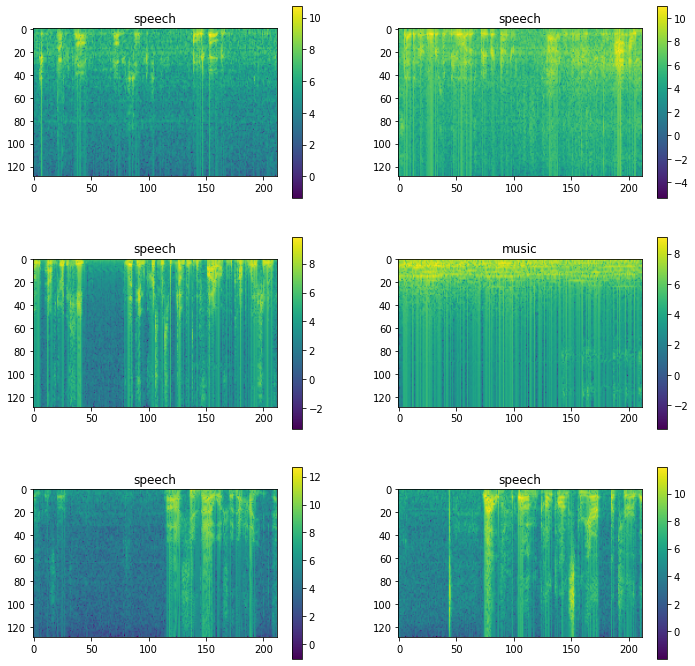

In [ ]:
plt.figure(figsize=(12, 12))

st = 0

for i in range(0, 6):
    x, y = x_train[st + i], y_train[st + i]

    plt.subplot(3, 2, i + 1)
    plt.imshow(x, cmap="viridis")
    plt.title(index_to_class[y.numpy()])
    plt.colorbar()
plt.show()

# Task 6: Create the Model

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Conv2D, BatchNormalization
from tensorflow.keras.layers import Activation, MaxPool2D, Flatten, Dropout, Dense

input_ = Input(shape=(129,212))
x = Lambda(lambda x: tf.expand_dims(x, axis = -1))(input_) #What does this do?

for i in range(0,4):
  num_filters = 2**(5 + i)
  x = Conv2D(num_filters, 3)(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  x = MaxPool2D(2)(x)

x = Flatten()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.4)(x)
x = Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(input_,x)

In [ ]:
model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 3e-6), metrics = ["accuracy"])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 129, 212)]        0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 129, 212, 1)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 127, 210, 32)      320       
_________________________________________________________________
batch_normalization_4 (Batch (None, 127, 210, 32)      128       
_________________________________________________________________
activation_4 (Activation)    (None, 127, 210, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 105, 32)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 103, 64)       1849

# Task 7: Model Training

In [ ]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, *args, **kwargs):
        super(CustomCallback, self).__init__(*args, **kwargs)
        self.target_acc = kwargs.get("target_acc") or 0.95 #Training stops when this accuracy is reached
        self.log_epoch = kwargs.get("log_epoch") or 5

    def on_epoch_end(self, epoch, logs=None):
        loss = logs.get("loss")
        acc = logs.get("accuracy")
        val_loss = logs.get("val_loss")
        val_acc = logs.get("val_accuracy")

        if (epoch + 1) % self.log_epoch == 0:
            print(f"Epoch: {epoch:3d}, Loss: {loss:.4f}, Acc: {acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        if val_acc >= self.target_acc:
            print("Target val accuracy achieved", val_acc)
            model.stop_training = True

In [ ]:
_ = model.fit(x_train, y_train, validation_data = (x_valid, y_valid), batch_size = 12, epochs = 500, verbose = False, callbacks=[CustomCallback()])

Epoch:   4, Loss: 0.6240, Acc: 0.7222, Val Loss: 0.9502, Val Acc: 0.4967
Epoch:   9, Loss: 0.4476, Acc: 0.7756, Val Loss: 0.7071, Val Acc: 0.6100
Epoch:  14, Loss: 0.3575, Acc: 0.8205, Val Loss: 0.2649, Val Acc: 0.8800
Epoch:  19, Loss: 0.3015, Acc: 0.8803, Val Loss: 0.2110, Val Acc: 0.9167
Epoch:  24, Loss: 0.2856, Acc: 0.8825, Val Loss: 0.1821, Val Acc: 0.9333
Epoch:  29, Loss: 0.2561, Acc: 0.8932, Val Loss: 0.1659, Val Acc: 0.9333
Epoch:  34, Loss: 0.2078, Acc: 0.9124, Val Loss: 0.1525, Val Acc: 0.9333
Epoch:  39, Loss: 0.1842, Acc: 0.9338, Val Loss: 0.1390, Val Acc: 0.9367
Epoch:  44, Loss: 0.1361, Acc: 0.9466, Val Loss: 0.1282, Val Acc: 0.9500
Target val accuracy achieved 0.9566666483879089


# Task 8: Predictions

In [ ]:
example = next(data_iter)

x_test, y_test = preprocess_example(example)

preds = model.predict(x_test)
pred_classes = tf.squeeze(tf.cast(preds > 0.5, tf.int8))

In [ ]:
pred_classes

<tf.Tensor: shape=(6,), dtype=int8, numpy=array([1, 1, 1, 1, 1, 1], dtype=int8)>

In [ ]:
y_test

<tf.Tensor: shape=(6,), dtype=int64, numpy=array([1, 1, 1, 1, 1, 1])>

In [ ]:
#As we can see, the two are matching!

#For the final prediction, what we can do is that we take the mode of 6 pred_classes and then print the final results. That will
#be a very good prediction, as then even if out of a 30 s audio clip the model predicts one 5s sample incorrectly, then the mode data will 
#over-ride it.

#Questions:

1. Are there other models which we can use to approach this problem? (see FCNN paper)
2. What other modifications can we make to this model?
